In [1]:
#Plot the measured spectra and do bkg subtraction

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

exec(open("nb_setup.py").read())
from constants import *

../mplstyles
3.1.1
/data/chocula/mast/cdms/analysis/run068/R68_paper2019/mplstyles


In [2]:
import R68_load as r68
import R68_efficiencies as eff
meas=r68.load_measured()

Loading Measured Data...
PuBe events:  (476731,)
Bkg events:  (174636,)


In [3]:
Emax = 2000 #eVee
Ebins=np.linspace(0,Emax,201)
Ebins_ctr=(Ebins[:-1]+Ebins[1:])/2
Efit_min=50#[eVee]
Efit_max=1750#[eVee]
spec_bounds=(np.digitize(Efit_min,Ebins)-1,np.digitize(Efit_max,Ebins)-1)

In [4]:
Ebins_ctr[slice(*spec_bounds)].shape

(170,)

In [5]:
#Measured
N_meas_PuBe,_ = np.histogram(meas['PuBe']['E'],bins=Ebins)
N_meas_Bkg,_ = np.histogram(meas['Bkg']['E'],bins=Ebins)
#Count uncertainties are Poisson
dN_meas_PuBe_Pois=np.sqrt(N_meas_PuBe)
dN_meas_Bkg_Pois=np.sqrt(N_meas_Bkg)

#Include uncertainty from efficiencies
dN_meas_PuBe = N_meas_PuBe*np.sqrt( (dN_meas_PuBe_Pois/N_meas_PuBe)**2 + (eff.deff_write/eff.eff_write)**2 +
                                   (eff.dcutEffFit(Ebins_ctr)/eff.cutEffFit(Ebins_ctr))**2)
dN_meas_Bkg = N_meas_Bkg*np.sqrt( (dN_meas_Bkg_Pois/N_meas_Bkg)**2 + (eff.deff_write_bkg/eff.eff_write_bkg)**2 +
                                   (eff.dcutEffFit_bkg(Ebins_ctr)/eff.cutEffFit_bkg(Ebins_ctr))**2)
#Scaling factors
tlive_ratio=meas['PuBe']['tlive']/meas['Bkg']['tlive']
writeEff_ratio=eff.eff_write/eff.eff_write_bkg
dwriteEff_ratio=writeEff_ratio*np.sqrt( (eff.deff_write/eff.eff_write)**2 + (eff.deff_write_bkg/eff.eff_write_bkg)**2 )

cutEff_ratio=eff.cutEffFit(Ebins_ctr)/eff.cutEffFit_bkg(Ebins_ctr)
dcutEff_ratio = cutEff_ratio*np.sqrt( (eff.dcutEffFit(Ebins_ctr)/eff.cutEffFit(Ebins_ctr))**2 + 
                                     (eff.dcutEffFit_bkg(Ebins_ctr)/eff.cutEffFit_bkg(Ebins_ctr))**2 )

ratio=tlive_ratio*writeEff_ratio*cutEff_ratio
dratio=ratio*np.sqrt( (dwriteEff_ratio/writeEff_ratio)**2 +(dcutEff_ratio/cutEff_ratio)**2 )

#Make sure any divide by 0s happened below threshold
if (not np.all(np.isfinite(ratio[slice(*spec_bounds)]))) or (not np.all(np.isfinite(dratio[slice(*spec_bounds)]))):
    print('Error: Bad background scaling ratio in fit range.')

#Bkg-subtracted measured PuBe signal
N_bkg_scaled=N_meas_Bkg*ratio
dN_bkg_scaled=N_bkg_scaled*np.sqrt( (dN_meas_Bkg/N_meas_Bkg)**2 + (dratio/ratio)**2 )

N_meas = N_meas_PuBe - N_bkg_scaled
dN_meas = np.sqrt( dN_meas_PuBe**2 + dN_bkg_scaled**2 ) #All errors are symmetric here when using the conservative cut eff fits
dN_meas_stat = np.sqrt( dN_meas_PuBe_Pois**2 + (dN_meas_Bkg_Pois*ratio)**2 )

/home/mastx027/python/miniconda3/envs/nr_fano/lib/python3.6/site-packages/ipykernel_launcher.py:12: RuntimeWarning: divide by zero encountered in true_divide
  if sys.path[0] == '':
/home/mastx027/python/miniconda3/envs/nr_fano/lib/python3.6/site-packages/ipykernel_launcher.py:18: RuntimeWarning: divide by zero encountered in true_divide
/home/mastx027/python/miniconda3/envs/nr_fano/lib/python3.6/site-packages/ipykernel_launcher.py:20: RuntimeWarning: divide by zero encountered in true_divide
/home/mastx027/python/miniconda3/envs/nr_fano/lib/python3.6/site-packages/ipykernel_launcher.py:23: RuntimeWarning: invalid value encountered in true_divide


/home/mastx027/python/miniconda3/envs/nr_fano/lib/python3.6/site-packages/matplotlib/axes/_axes.py:3370: RuntimeWarning: invalid value encountered in double_scalars
  low = [v - e for v, e in zip(data, a)]
findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.


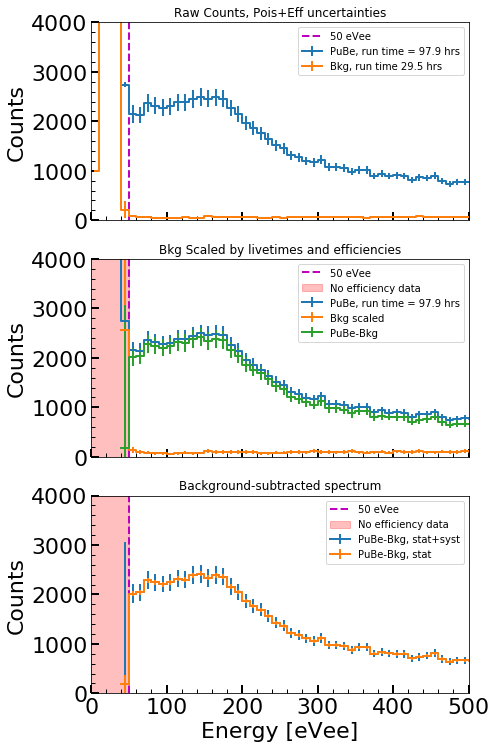

In [6]:
fig_w=7
fig,ax = plt.subplots(3,1,figsize=(fig_w, 2*fig_w*(.75)),sharex=True)

#Raw Count histograms
ax[0].set_title('Raw Counts, Pois+Eff uncertainties')

ax[0].errorbar(Ebins_ctr,N_meas_PuBe,yerr=dN_meas_PuBe, drawstyle = 'steps-mid', linewidth=2,
               label='PuBe, run time = {0:.1f} hrs'.format(meas['PuBe']['tlive']/3600))
ax[0].errorbar(Ebins_ctr,N_meas_Bkg,yerr=dN_meas_Bkg, drawstyle = 'steps-mid', linewidth=2,
               label='Bkg, run time {0:.1f} hrs'.format(meas['Bkg']['tlive']/3600))
ax[0].axvline(50,linestyle='--',color='m', label='50 eVee')

ax[0].set_xlim(0,5e2)
#ax[0].set_yscale('log')
ax[0].set_ylim(0,4e3)
ax[0].set_ylabel('Counts')
ax[0].legend()

#Scale Bkg
ax[1].set_title('Bkg Scaled by livetimes and efficiencies')

ax[1].errorbar(Ebins_ctr,N_meas_PuBe,yerr=dN_meas_PuBe, drawstyle = 'steps-mid', linewidth=2,
               label='PuBe, run time = {0:.1f} hrs'.format(meas['PuBe']['tlive']/3600))
ax[1].errorbar(Ebins_ctr,N_bkg_scaled,yerr=dN_bkg_scaled, drawstyle = 'steps-mid', linewidth=2,
               label='Bkg scaled')
ax[1].errorbar(Ebins_ctr,N_meas,yerr=dN_meas, drawstyle = 'steps-mid', linewidth=2,
               label='PuBe-Bkg')
ax[1].axvline(50,linestyle='--',color='m', label='50 eVee')
ax[1].axvspan(0,50,color='r', alpha=0.25, label='No efficiency data',zorder=0)

ax[1].set_ylim(0,4e3)
#ax[1].set_yscale('log')
ax[1].set_ylabel('Counts')
ax[1].legend()

#Background-subtracted spectrum
ax[2].set_title('Background-subtracted spectrum')
ax[2].errorbar(Ebins_ctr,N_meas,yerr=dN_meas, drawstyle = 'steps-mid', linewidth=2,
               label='PuBe-Bkg, stat+syst')
ax[2].errorbar(Ebins_ctr,N_meas,yerr=dN_meas_stat, drawstyle = 'steps-mid', linewidth=2,
               label='PuBe-Bkg, stat')
ax[2].axvline(50,linestyle='--',color='m', label='50 eVee')
ax[2].axvspan(0,50,color='r', alpha=0.25, label='No efficiency data',zorder=0)
ax[2].set_ylim(0,4e3)
ax[2].set_ylabel('Counts')
ax[2].set_xlabel('Energy [eVee]')
ax[2].legend()


plt.tight_layout()
plt.savefig('figures/meas_spec_subtraction.png')
#plt.savefig('figures/meas_spec_subtraction.eps')

# Show alternate process of scaling back to reconstructed rate

/home/mastx027/python/miniconda3/envs/nr_fano/lib/python3.6/site-packages/ipykernel_launcher.py:24: RuntimeWarning: divide by zero encountered in true_divide
/home/mastx027/python/miniconda3/envs/nr_fano/lib/python3.6/site-packages/ipykernel_launcher.py:36: RuntimeWarning: divide by zero encountered in true_divide


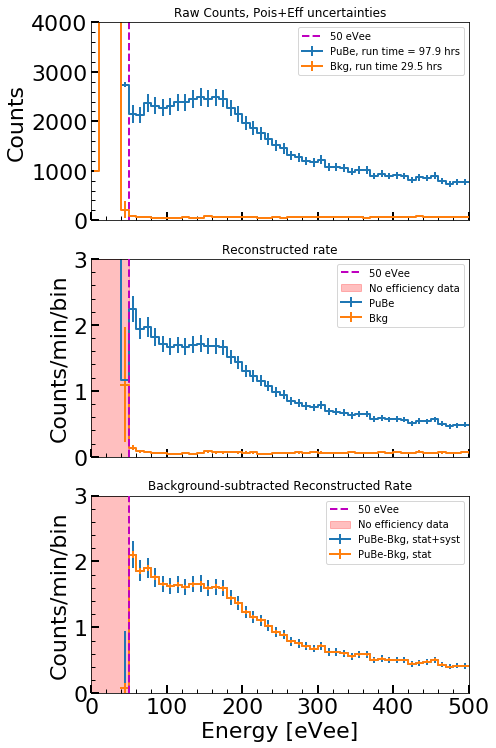

In [7]:
fig,ax = plt.subplots(3,1,figsize=(fig_w, 2*fig_w*(.75)),sharex=True)

#Raw Count histograms
ax[0].set_title('Raw Counts, Pois+Eff uncertainties')

ax[0].errorbar(Ebins_ctr,N_meas_PuBe,yerr=dN_meas_PuBe, drawstyle = 'steps-mid', linewidth=2,
               label='PuBe, run time = {0:.1f} hrs'.format(meas['PuBe']['tlive']/3600))
ax[0].errorbar(Ebins_ctr,N_meas_Bkg,yerr=dN_meas_Bkg, drawstyle = 'steps-mid', linewidth=2,
               label='Bkg, run time {0:.1f} hrs'.format(meas['Bkg']['tlive']/3600))
ax[0].axvline(50,linestyle='--',color='m', label='50 eVee')

ax[0].set_xlim(0,5e2)
#ax[0].set_yscale('log')
ax[0].set_ylim(0,4e3)
ax[0].set_ylabel('Counts')
ax[0].legend()

#Scale to reconstructed rate
ax[1].set_title('Reconstructed rate')

Denom_PuBe = meas['PuBe']['tlive']*eff.eff_write*eff.cutEffFit(Ebins_ctr)*eff.trigEff(Ebins_ctr)
R_meas_PuBe = N_meas_PuBe/Denom_PuBe
Denom_Bkg = meas['Bkg']['tlive']*eff.eff_write_bkg*eff.cutEffFit_bkg(Ebins_ctr)*eff.trigEff(Ebins_ctr)
R_meas_Bkg = N_meas_Bkg/Denom_Bkg

R_meas = R_meas_PuBe - R_meas_Bkg

dR_meas_stat_PuBe = R_meas_PuBe*dN_meas_PuBe_Pois/N_meas_PuBe
dR_meas_PuBe = R_meas_PuBe*np.sqrt( (dN_meas_PuBe_Pois/N_meas_PuBe)**2 +\
                                   (eff.deff_write/eff.eff_write)**2 +\
                                   (eff.dcutEffFit(Ebins_ctr)/eff.cutEffFit(Ebins_ctr))**2 +\
                                   (eff.dtrigEff(Ebins_ctr)/eff.trigEff(Ebins_ctr))**2 )
dR_meas_stat_Bkg = R_meas_Bkg*dN_meas_Bkg_Pois/N_meas_Bkg
dR_meas_Bkg = R_meas_Bkg*np.sqrt( (dN_meas_Bkg_Pois/N_meas_Bkg)**2 +\
                                 (eff.deff_write_bkg/eff.eff_write_bkg)**2 +\
                                 (eff.dcutEffFit_bkg(Ebins_ctr)/eff.cutEffFit_bkg(Ebins_ctr))**2 +\
                                 (eff.dtrigEff(Ebins_ctr)/eff.trigEff(Ebins_ctr))**2 )

dR_meas_stat = np.sqrt(dR_meas_stat_PuBe**2 + dR_meas_stat_Bkg**2)
dR_meas = np.sqrt(dR_meas_PuBe**2 + dR_meas_Bkg**2)


ax[1].errorbar(Ebins_ctr,60*R_meas_PuBe,yerr=60*dR_meas_PuBe, drawstyle = 'steps-mid', linewidth=2,
               label='PuBe')
ax[1].errorbar(Ebins_ctr,60*R_meas_Bkg,yerr=60*dR_meas_Bkg, drawstyle = 'steps-mid', linewidth=2,
               label='Bkg')

ax[1].axvline(50,linestyle='--',color='m', label='50 eVee',zorder=5)
ax[1].axvspan(0,50,color='r', alpha=0.25, label='No efficiency data',zorder=0)

ax[1].set_ylim(0,3)
#ax[1].set_yscale('log')
ax[1].set_ylabel('Counts/min/bin')
ax[1].legend()

#Background-subtracted spectrum
ax[2].set_title('Background-subtracted Reconstructed Rate')
ax[2].errorbar(Ebins_ctr,60*R_meas,yerr=60*dR_meas, drawstyle = 'steps-mid', linewidth=2,
               label='PuBe-Bkg, stat+syst')
ax[2].errorbar(Ebins_ctr,60*R_meas,yerr=60*dR_meas_stat, drawstyle = 'steps-mid', linewidth=2,
               label='PuBe-Bkg, stat')
ax[2].axvline(50,linestyle='--',color='m', label='50 eVee',zorder=5)
ax[2].axvspan(0,50,color='r', alpha=0.25, label='No efficiency data',zorder=0)
ax[2].set_ylim(0,3)
ax[2].set_ylabel('Counts/min/bin')
ax[2].set_xlabel('Energy [eVee]')
ax[2].legend()


plt.tight_layout()
plt.savefig('figures/meas_spec_reco_rate.png')

# Test functionality of load_measured and doBkgSub functions

In [8]:
import R68_spec_tools as spec
c_stat,dc_stat=spec.doBkgSub(r68.load_measured(verbose=False), Ebins, Efit_min, Efit_max, doEffsyst=False, doBurstLeaksyst=False, output='counts')
c_syst,dc_syst=spec.doBkgSub(r68.load_measured(verbose=False), Ebins, Efit_min, Efit_max, doEffsyst=True, doBurstLeaksyst=False, output='counts')
c_syst2,dc_syst2=spec.doBkgSub(r68.load_measured(verbose=False), Ebins, Efit_min, Efit_max, doEffsyst=True, doBurstLeaksyst=True, output='counts')

r_stat,dr_stat=spec.doBkgSub(r68.load_measured(verbose=False), Ebins, Efit_min, Efit_max, doEffsyst=False, doBurstLeaksyst=False, output='reco-rate')
r_syst,dr_syst=spec.doBkgSub(r68.load_measured(verbose=False), Ebins, Efit_min, Efit_max, doEffsyst=True, doBurstLeaksyst=False, output='reco-rate')
r_syst2,dr_syst2=spec.doBkgSub(r68.load_measured(verbose=False), Ebins, Efit_min, Efit_max, doEffsyst=True, doBurstLeaksyst=True, output='reco-rate')

../python/R68_spec_tools.py:55: RuntimeWarning: divide by zero encountered in true_divide
  (eff.dcutEffFit_bkg(Ebins_ctr)/eff.cutEffFit_bkg(Ebins_ctr))**2 +\
../python/R68_spec_tools.py:80: RuntimeWarning: divide by zero encountered in true_divide
  N_bkg_scaled=N_meas_Bkg*TE_PuBe/TE_Bkg
../python/R68_spec_tools.py:96: RuntimeWarning: divide by zero encountered in true_divide
  doEffsyst*(eff.dcutEffFit_bkg(Ebins_ctr)/eff.cutEffFit_bkg(Ebins_ctr))**2)
../python/R68_spec_tools.py:96: RuntimeWarning: invalid value encountered in multiply
  doEffsyst*(eff.dcutEffFit_bkg(Ebins_ctr)/eff.cutEffFit_bkg(Ebins_ctr))**2)
../python/R68_spec_tools.py:100: RuntimeWarning: invalid value encountered in multiply
  doEffsyst*(dTE_Bkg/TE_Bkg)**2 )
../python/R68_spec_tools.py:60: RuntimeWarning: divide by zero encountered in true_divide
  R_meas_Bkg = N_meas_Bkg/TE_Bkg
../python/R68_spec_tools.py:69: RuntimeWarning: invalid value encountered in multiply
  doEffsyst*(dTE_Bkg/TE_Bkg)**2 )


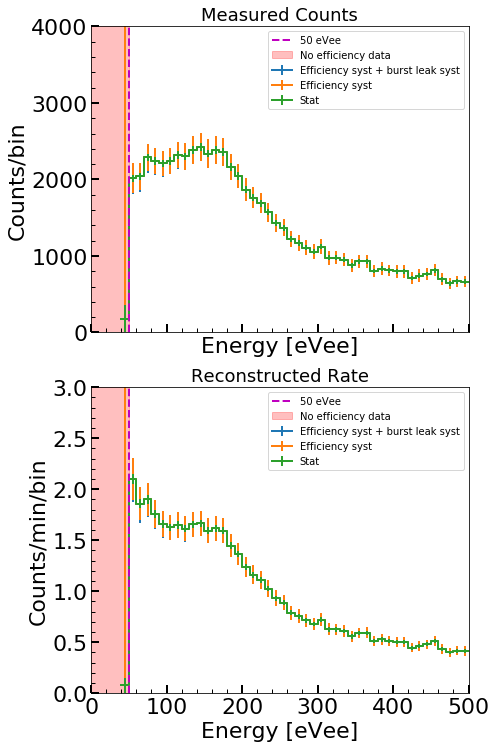

In [14]:
fig,ax = plt.subplots(2,1,figsize=(fig_w, 2*fig_w*(.75)) ,sharex=True)
#Reverse errorbar order to be [lower,upper]
ax[0].set_title('Measured Counts',size='18')
ax[0].errorbar(Ebins_ctr,c_syst2,yerr=dc_syst2[::-1],drawstyle = 'steps-mid', linewidth=2, label='Efficiency syst + burst leak syst')
ax[0].errorbar(Ebins_ctr,c_syst,yerr=dc_syst[::-1],drawstyle = 'steps-mid', linewidth=2, label='Efficiency syst')
ax[0].errorbar(Ebins_ctr,c_stat,yerr=dc_stat[::-1],drawstyle = 'steps-mid', linewidth=2, label='Stat')
ax[0].set_ylim(0,4e3)
#ax[0].set_ylim(1.5e3,3e3)
#ax[0].set_xlim(0,200)
ax[0].set_ylabel('Counts/bin')
ax[0].set_xlabel('Energy [eVee]')

ax[1].set_title('Reconstructed Rate',size='18')
ax[1].errorbar(Ebins_ctr,60*r_syst2,yerr=60*dr_syst2[::-1],drawstyle = 'steps-mid', linewidth=2, label='Efficiency syst + burst leak syst')
ax[1].errorbar(Ebins_ctr,60*r_syst,yerr=60*dr_syst[::-1],drawstyle = 'steps-mid', linewidth=2, label='Efficiency syst')
ax[1].errorbar(Ebins_ctr,60*r_stat,yerr=60*dr_stat[::-1],drawstyle = 'steps-mid', linewidth=2, label='Stat')
ax[1].set_ylim(0,3)
ax[1].set_xlim(0,500)
ax[1].set_ylabel('Counts/min/bin')
ax[1].set_xlabel('Energy [eVee]')

for axi in ax:
    axi.axvline(50,linestyle='--',color='m', label='50 eVee',zorder=5)
    axi.axvspan(0,50,color='r', alpha=0.25, label='No efficiency data',zorder=0)
    axi.legend()

plt.tight_layout()

# Pretty plot for paper

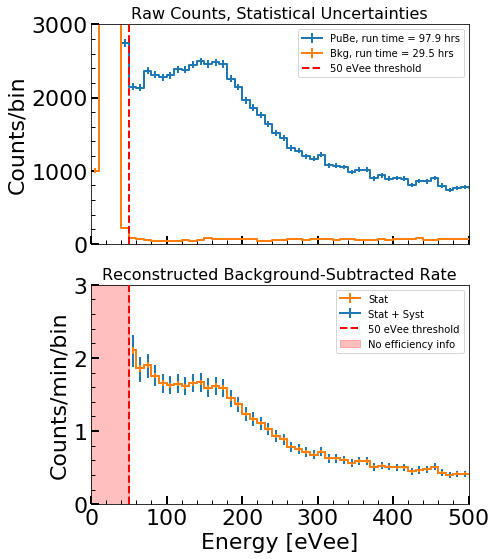

In [70]:
fig,ax = plt.subplots(2,1,figsize=(fig_w, 1.5*fig_w*(.75)) ,sharex=True)

cthresh=Ebins_ctr>=50 #Only plot hists above threshold

#Raw Count histograms
ax[0].set_title('Raw Counts, Statistical Uncertainties',size='16')

line_c_PuBe=ax[0].errorbar(Ebins_ctr,N_meas_PuBe,yerr=dN_meas_PuBe_Pois, drawstyle = 'steps-mid', linewidth=2)
line_c_Bkg=ax[0].errorbar(Ebins_ctr,N_meas_Bkg,yerr=dN_meas_Bkg_Pois, drawstyle = 'steps-mid', linewidth=2)
line_thresh=ax[0].axvline(50,linestyle='--',color='r', label='50 eVee threshold',zorder=5)

ax[0].set_xlim(0,5e2)
#ax[0].set_yscale('log')
ax[0].set_ylim(0,3e3)
ax[0].set_ylabel('Counts/bin')


ax[0].legend([line_c_PuBe, line_c_Bkg, line_thresh, fill_noise],
             [f"PuBe, run time = {meas['PuBe']['tlive']/3600:.1f} hrs",
              f"Bkg, run time = {meas['Bkg']['tlive']/3600:.1f} hrs",
              '50 eVee threshold'])
     
                                       
#Reconstructed rate
                                       
#Reverse errorbar order to be [lower,upper]
ax[1].set_title('Reconstructed Background-Subtracted Rate',size='16')
line_r_syst=ax[1].errorbar(Ebins_ctr[cthresh],60*r_syst2[cthresh],yerr=(60*dr_syst2[::-1])[:,cthresh],drawstyle = 'steps-mid', linewidth=2, label='Stat + Syst')
#ax[1].errorbar(Ebins_ctr,60*r_syst,yerr=60*dr_syst[::-1],drawstyle = 'steps-mid', linewidth=2, label='Efficiency syst')
line_r_stat=ax[1].errorbar(Ebins_ctr[cthresh],60*r_stat[cthresh],yerr=60*dr_stat[::-1][:,cthresh],drawstyle = 'steps-mid', linewidth=2, label='Stat')
                                       
line_thresh=ax[1].axvline(50,linestyle='--',color='r', label='50 eVee threshold',zorder=5)
fill_noise=ax[1].axvspan(0,50,color='r', alpha=0.25, label='No efficiency data',zorder=0)
                                       
ax[1].legend([line_r_stat, line_r_syst, line_thresh, fill_noise],
             ['Stat', 'Stat + Syst', '50 eVee threshold', 'No efficiency info'])
    
ax[1].set_ylim(0,3)
ax[1].set_xlim(0,500)
ax[1].set_ylabel('Counts/min/bin')
ax[1].set_xlabel('Energy [eVee]')


plt.tight_layout()
plt.savefig('figures/meas_spec_reco_rate_pretty.png')

# Test likelihood map building

In [10]:
#Copy these functions from Asym_incertainty_fit notebook
from scipy import special
#Standard Normal probability density function
def fN(x):
    return (1/np.sqrt(2*np.pi))*np.exp(-(x**2)/2)
#Standard Normal CDF
def cN(k):
    return (1+special.erf(k/np.sqrt(2)))/2
#Quantile function of the standard normal distribution
def qN(q):
    return np.sqrt(2)*special.erfinv(2*q-1)

#Split-normal probability density function
def fSN(x,mu,sigma1,sigma2):
    x=np.asarray(x)
    prob=np.zeros_like(x)
    C=np.sqrt(2/np.pi)/(sigma1+sigma2)
    prob[x<=mu]=C*np.exp(-((x[x<=mu]-mu)/sigma1)**2/2)
    prob[x>mu]=C*np.exp(-((x[x>mu]-mu)/sigma2)**2/2)
    return prob
#CDF of Split-Normal (Eq 2.8 of Julio)
def cSN(k,mu,sigma1,sigma2):
    k=np.asarray(k)
    prob=np.zeros_like(k)
    C=np.sqrt(2/np.pi)/(sigma1+sigma2)
    prob[k<=mu]=C*np.sqrt(2*np.pi)*sigma1*cN((k[k<=mu]-mu)/sigma1)
    prob[k>mu]=1-C*np.sqrt(2*np.pi)*sigma2*(1-cN((k[k>mu]-mu)/sigma2))
    return prob
#Quantile function of the Split-Normal distribution (Eq 2.9 of Julio)
def qSN(q,mu,sigma1,sigma2):
    q=np.asarray(q)
    C=np.sqrt(2/np.pi)/(sigma1+sigma2)
    p=cSN(mu,mu,sigma1,sigma2)
    k=np.zeros_like(q)
    k[q<=p]=mu+sigma1*qN(q[q<=p]/(C*sigma1*np.sqrt(2*np.pi)))
    k[q>p]=mu+sigma2*qN((q[q>p]+C*sigma2*np.sqrt(2*np.pi)-1)/(C*sigma2*np.sqrt(2*np.pi)))
    return k
#For a given set of median and upper and lower quantile points, find the best fit split gaussian to them
#xs: points
#qs: quantiles, e.g. [0.15865,0.5,0.84135] for median and +/- 1-sigma
#w: array of weighting factors for target points. Default = uniform
#mode: Can perscribe a mode exactly
#bounds: bounds of mu,sigma1,sigma2 values in the form ((mu_low,muhi),(sigma1_low,sigma1_hi),(sigma2_low,sigma2_hi))
#   Values can be None. Recommend using small lower values to keep them non-zero.
#Returns: best fit mu,sigma1,sigma2
from scipy.optimize import minimize
def getSNpars(xs,qs,w=None,mode=None,bounds=((1e-12,None),(1e-12,None),(1e-12,None))):
    xs=np.asarray(xs)
    qs=np.asarray(qs)
    if w is None:
        w=np.ones_like(xs)
    else:
        w=np.asarray(w)
        
    if mode is None:
        #theta = [mode,sigma1,sigma2]
        chisq = lambda theta: np.sum(w*(xs - qSN(qs,*theta))**2)
        #Crude estimate of mode and sigmas to initialize fit
        pfit = np.poly1d(np.polyfit(qs,xs,deg=1))
        #plot(pfit(qs),qs)
        x0=pfit([0.5,0.15865,0.84135])
        theta0=np.array([x0[0],x0[0]-x0[1],x0[2]-x0[0]])

        res=minimize(chisq,theta0,bounds=bounds)
        return res['x']
        
    else:
        #theta = [sigma1,sigma2], mode is fixed
        chisq = lambda theta: np.sum(w*( xs - qSN(qs,mode,*theta))**2)
        #We know the mode exactly, just need sigmas
        pfit = np.poly1d(np.polyfit([0.5,*qs],[mode,*xs],deg=1))
        x0=pfit([0.15865,0.84135])
        theta0=np.array([mode-x0[0],x0[1]-mode])
        
        res=minimize(chisq,theta0,bounds=bounds[1:])
        return np.insert(res['x'],0,mode)

/home/mastx027/python/miniconda3/envs/nr_fano/lib/python3.6/site-packages/ipykernel_launcher.py:46: RuntimeWarning: invalid value encountered in subtract
/home/mastx027/python/miniconda3/envs/nr_fano/lib/python3.6/site-packages/ipykernel_launcher.py:50: RuntimeWarning: invalid value encountered in subtract


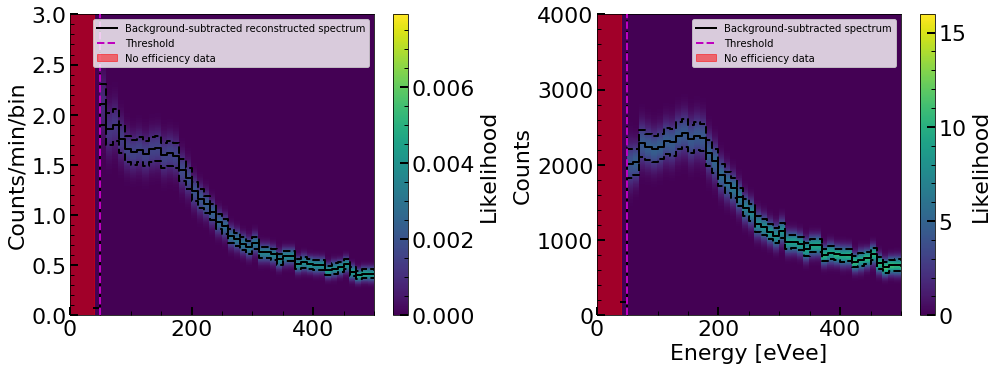

In [38]:
import likelihoods as lk

fig_w=7
fig,ax = plt.subplots(1,2,figsize=(2*fig_w, fig_w*(.75)),sharex=True)

popt_c_syst=lk.getSNparsArray(c_syst[slice(*spec_bounds)],dc_syst[0][slice(*spec_bounds)],dc_syst[1][slice(*spec_bounds)])
popt_r_syst=lk.getSNparsArray(60*r_syst[slice(*spec_bounds)],60*dr_syst[0][slice(*spec_bounds)],60*dr_syst[1][slice(*spec_bounds)]) #c/min

#Counts
ybins=np.linspace(0,4e3,1000)
ybins_ctr=(ybins[:-1]+ybins[1:])/2
bins2d=(Ebins,ybins)
counts=None
for E,popti in zip(Ebins_ctr[slice(*spec_bounds)],popt_c_syst):
    c=np.histogram2d(np.repeat(E,len(ybins_ctr)),ybins_ctr,weights=lk.fSN(ybins_ctr,*popti),bins=bins2d)[0]
    if counts is None:
        counts=c
    else:
        counts+=c
        
X, Y = np.meshgrid(Ebins,ybins)
mesh=ax[1].pcolormesh(X, Y, counts.T,cmap=plt.get_cmap('viridis'))
cbar=plt.colorbar(mesh,ax=ax[0])
cbar.set_label('Likelihood')

###Rate
ybins=np.linspace(0,3,1000)
ybins_ctr=(ybins[:-1]+ybins[1:])/2
bins2d=(Ebins,ybins)
counts=None
for E,popti in zip(Ebins_ctr[slice(*spec_bounds)],popt_r_syst):
    c=np.histogram2d(np.repeat(E,len(ybins_ctr)),ybins_ctr,weights=lk.fSN(ybins_ctr,*popti),bins=bins2d)[0]
    if counts is None:
        counts=c
    else:
        counts+=c
        
X, Y = np.meshgrid(Ebins,ybins)
mesh=ax[0].pcolormesh(X, Y, counts.T,cmap=plt.get_cmap('viridis'))
cbar=plt.colorbar(mesh,ax=ax[1])
cbar.set_label('Likelihood')

#Overlay values and uncertainty range
ax[1].step(Ebins_ctr, c_syst, color='k', linewidth=2, where='mid',zorder=3,label='Background-subtracted spectrum')
ax[1].step(Ebins_ctr, c_syst+dc_syst[0], color='k', linestyle='--', linewidth=2, where='mid',zorder=3)
ax[1].step(Ebins_ctr, c_syst-dc_syst[0], color='k', linestyle='--', linewidth=2, where='mid',zorder=3)

ax[0].step(Ebins_ctr, 60*r_syst, color='k', linewidth=2, where='mid',zorder=3,label='Background-subtracted reconstructed spectrum')
ax[0].step(Ebins_ctr, 60*(r_syst+dr_syst[0]), color='k', linestyle='--', linewidth=2, where='mid',zorder=3)
ax[0].step(Ebins_ctr, 60*(r_syst-dr_syst[0]), color='k', linestyle='--', linewidth=2, where='mid',zorder=3)

for axi in ax:
    axi.axvline(50,linestyle='--',color='m', label='Threshold',zorder=4)
    axi.axvspan(0,40,color='r', alpha=0.5, label='No efficiency data')
    axi.legend()

ax[1].set_ylabel('Counts')
ax[0].set_ylabel('Counts/min/bin')

ax[1].set_xlabel('Energy [eVee]')
ax[0].set_xlim(0,500)
ax[1].set_xlim(0,500)
ax[1].set_ylim(0,4e3)
ax[0].set_ylim(0,3)


plt.tight_layout()
plt.savefig('figures/meas_spec_PDF.png')

3.0

# DEFUNCT BELOW HERE #

Also want to include uncertainty from the burst cut. So we just repeat the above exercise for the two extremes. Then we'll take the extreme values of each bin.

In [6]:
meas_hi=r68.load_measured(cLERate='Hi')
meas_low=r68.load_measured(cLERate='Low')
N_meas_PuBe_hi,_ = np.histogram(meas_hi['PuBe']['E'],bins=Ebins)
N_meas_PuBe_low,_ = np.histogram(meas_low['PuBe']['E'],bins=Ebins)
#Count uncertainties are Poisson
dN_meas_PuBe_Pois_hi=np.sqrt(N_meas_PuBe_hi)
dN_meas_PuBe_Pois_low=np.sqrt(N_meas_PuBe_low)

#Include uncertainty from efficiencies
dN_meas_PuBe_hi = N_meas_PuBe_hi*np.sqrt( (dN_meas_PuBe_Pois_hi/N_meas_PuBe_hi)**2 + (eff.deff_write/eff.eff_write)**2 +
                                   (eff.dcutEffFit(Ebins_ctr)/eff.cutEffFit(Ebins_ctr))**2)
dN_meas_PuBe_low = N_meas_PuBe_low*np.sqrt( (dN_meas_PuBe_Pois_low/N_meas_PuBe_low)**2 + (eff.deff_write/eff.eff_write)**2 +
                                   (eff.dcutEffFit(Ebins_ctr)/eff.cutEffFit(Ebins_ctr))**2)
#Scaling factors same as above

N_meas_hi = N_meas_PuBe_hi - N_bkg_scaled
N_meas_low = N_meas_PuBe_low - N_bkg_scaled
dN_meas_hi = np.sqrt( dN_meas_PuBe_hi**2 + dN_bkg_scaled**2 ) #All errors are symmetric here when using the conservative cut eff fits
dN_meas_low = np.sqrt( dN_meas_PuBe_low**2 + dN_bkg_scaled**2 )

Loading Measured Data...
PuBe events:  (484189,)
Bkg events:  (174510,)
Loading Measured Data...
PuBe events:  (462740,)
Bkg events:  (174510,)


/home/mastx027/python/miniconda3/envs/nr_fano/lib/python3.6/site-packages/ipykernel_launcher.py:11: RuntimeWarning: divide by zero encountered in true_divide
  # This is added back by InteractiveShellApp.init_path()
/home/mastx027/python/miniconda3/envs/nr_fano/lib/python3.6/site-packages/ipykernel_launcher.py:13: RuntimeWarning: divide by zero encountered in true_divide
  del sys.path[0]


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript back

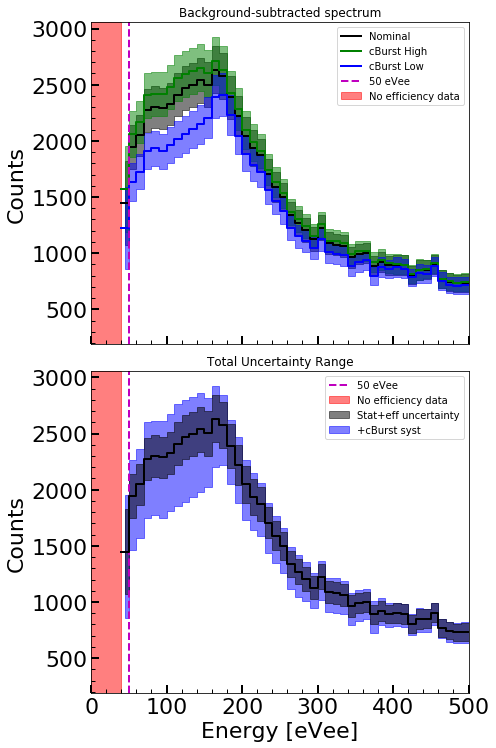

In [7]:
fig,ax = plt.subplots(2,1,figsize=(fig_w, 2*fig_w*(.75)),sharex=True)
ax[0].set_title('Background-subtracted spectrum')

#ax[0].errorbar(Ebins_ctr,N_meas,yerr=dN_meas, drawstyle = 'steps-mid', color='k', linewidth=2,
#               label='Nominal')
#ax[0].errorbar(Ebins_ctr,N_meas_hi,yerr=dN_meas_hi, drawstyle = 'steps-mid', color='r', linewidth=2,
#               label='cBurst High')
#ax[0].errorbar(Ebins_ctr,N_meas_low,yerr=dN_meas_low, drawstyle = 'steps-mid', color='b', linewidth=2,
#               label='cBurst Low')
ax[0].fill_between(Ebins_ctr, N_meas-dN_meas, N_meas+dN_meas, step='mid', color='k',alpha=0.5)
ax[0].fill_between(Ebins_ctr, N_meas_hi-dN_meas_hi, N_meas_hi+dN_meas_hi, step='mid', color='g',alpha=0.5)
ax[0].fill_between(Ebins_ctr, N_meas_low-dN_meas_low, N_meas_low+dN_meas_low, step='mid', color='b',alpha=0.5)

ax[0].step(Ebins_ctr, N_meas, color='k', linewidth=2, where='mid', label='Nominal')
ax[0].step(Ebins_ctr, N_meas_hi, color='g', linewidth=2, where='mid', label='cBurst High')
ax[0].step(Ebins_ctr, N_meas_low, color='b', linewidth=2, where='mid', label='cBurst Low')


ax[0].axvline(50,linestyle='--',color='m', label='50 eVee')
ax[0].axvspan(0,40,color='r', alpha=0.5, label='No efficiency data')
ax[0].set_ylabel('Counts')
ax[0].legend()

#Take extreme values
ax[1].set_title('Total Uncertainty Range')

ax[1].step(Ebins_ctr, N_meas, color='k', linewidth=2, where='mid',zorder=3)
ax[1].fill_between(Ebins_ctr, N_meas-dN_meas, N_meas+dN_meas, step='mid', color='k',alpha=0.5,
                   label='Stat+eff uncertainty',zorder=2)
ax[1].fill_between(Ebins_ctr, N_meas_low-dN_meas_low, N_meas_hi+dN_meas_hi, step='mid', color='b', alpha=0.5,
                   label='+cBurst syst',zorder=1)

ax[1].axvline(50,linestyle='--',color='m', label='50 eVee')
ax[1].axvspan(0,40,color='r', alpha=0.5, label='No efficiency data')
ax[1].set_ylabel('Counts')

ax[1].set_xlabel('Energy [eVee]')
#ax[1].set_xlim(0,1e3)
ax[1].set_xlim(0,5e2)
ax[1].legend()

plt.tight_layout()
plt.savefig('figures/meas_spec_cBurstSyst.png')
plt.savefig('figures/meas_spec_cBurstSyst.eps')

Now we also want to fit each bin value and uncertainty with the Split-Normal distribution so we have the PDF for each bin that we can then use to calculate the likelihood of a simulated spectra.

In [9]:
popt=[]
N_meas_m1sig=N_meas_low-dN_meas_low
N_meas_p1sig=N_meas_hi+dN_meas_hi
cGoodE=Ebins_ctr>50
for mode,m1sig,p1sig in zip(N_meas[cGoodE],N_meas_m1sig[cGoodE],N_meas_p1sig[cGoodE]):
    popt.append(getSNpars([m1sig,p1sig],[0.15865,0.84135],w=[1,1],mode=mode))
popt=np.array(popt)

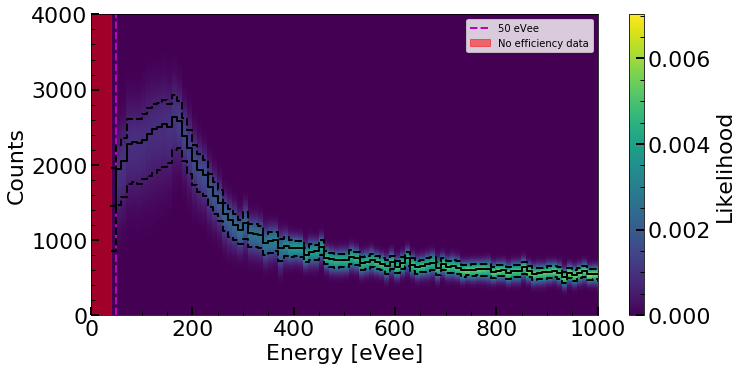

In [10]:
#Draw PDF in each bin
from matplotlib.colors import LogNorm
fig,ax = plt.subplots(1,1,figsize=(1.5*fig_w, fig_w*(.75)),sharex=True)

ybins=np.linspace(0,4e3,1000)
ybins_ctr=(ybins[:-1]+ybins[1:])/2
bins2d=(Ebins,ybins)
counts=None
for E,popti in zip(Ebins_ctr[cGoodE],popt):
    c=np.histogram2d(np.repeat(E,len(ybins_ctr)),ybins_ctr,weights=fSN(ybins_ctr,*popti),bins=bins2d)[0]
    if counts is None:
        counts=c
    else:
        counts+=c
        
X, Y = np.meshgrid(Ebins,ybins)
mesh=ax.pcolormesh(X, Y, counts.T,cmap=plt.get_cmap('viridis'))

#Overlay values and uncertainty range
ax.step(Ebins_ctr, N_meas, color='k', linewidth=2, where='mid',zorder=3)
ax.step(Ebins_ctr, N_meas_m1sig, color='k', linestyle='--', linewidth=2, where='mid',zorder=3)
ax.step(Ebins_ctr, N_meas_p1sig, color='k', linestyle='--', linewidth=2, where='mid',zorder=3)

ax.axvline(50,linestyle='--',color='m', label='50 eVee')
ax.axvspan(0,40,color='r', alpha=0.5, label='No efficiency data')
ax.set_ylabel('Counts')

ax.set_xlabel('Energy [eVee]')
ax.set_xlim(0,1e3)
#ax.set_xlim(0,5e2)
ax.legend()
cbar=plt.colorbar(mesh,ax=ax)
cbar.set_label('Likelihood')
plt.tight_layout()

Built the above code into R68_spec_tools

Test the functionality here. 
# Looks good!

In [5]:
import R68_spec_tools as spec
c,dc=spec.doBkgSub(r68.load_measured(cLERate='Nom',verbose=False), Ebins, Efit_min, Efit_max, doLERsyst=False, output='reco-rate')
c2,dc2=spec.doBkgSub(r68.load_measured(cLERate='Nom',verbose=False), Ebins, Efit_min, Efit_max, doLERsyst=True, output='reco-rate')
c3,dc3=spec.doBkgSub(r68.load_measured(cLERate='Hi',verbose=False), Ebins, Efit_min, Efit_max, doLERsyst=False, output='reco-rate')
c4,dc4=spec.doBkgSub(r68.load_measured(cLERate='Low',verbose=False), Ebins, Efit_min, Efit_max, doLERsyst=False, output='reco-rate')

../python/R68_spec_tools.py:139: RuntimeWarning: divide by zero encountered in true_divide
  R_meas_PuBe = N_meas_PuBe/Denom_PuBe
../python/R68_spec_tools.py:141: RuntimeWarning: divide by zero encountered in true_divide
  R_meas_Bkg = N_meas_Bkg/Denom_Bkg
../python/R68_spec_tools.py:143: RuntimeWarning: invalid value encountered in subtract
  R_meas = R_meas_PuBe - R_meas_Bkg
../python/R68_spec_tools.py:148: RuntimeWarning: divide by zero encountered in true_divide
  doEffsyst*(eff.dcutEffFit(Ebins_ctr)/eff.cutEffFit(Ebins_ctr))**2 +\
../python/R68_spec_tools.py:152: RuntimeWarning: divide by zero encountered in true_divide
  doEffsyst*(eff.dcutEffFit_bkg(Ebins_ctr)/eff.cutEffFit_bkg(Ebins_ctr))**2 +\
../python/R68_spec_tools.py:168: RuntimeWarning: divide by zero encountered in true_divide
  R_meas_PuBe_hi = N_meas_PuBe_hi/Denom_PuBe
../python/R68_spec_tools.py:169: RuntimeWarning: divide by zero encountered in true_divide
  R_meas_PuBe_low = N_meas_PuBe_low/Denom_PuBe
../python/R68_

/home/mastx027/python/miniconda3/envs/nr_fano/lib/python3.6/site-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in subtract
  This is separate from the ipykernel package so we can avoid doing imports until
/home/mastx027/python/miniconda3/envs/nr_fano/lib/python3.6/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in subtract
  if __name__ == '__main__':
/home/mastx027/python/miniconda3/envs/nr_fano/lib/python3.6/site-packages/ipykernel_launcher.py:12: RuntimeWarning: invalid value encountered in subtract
  if sys.path[0] == '':


(0, 500)

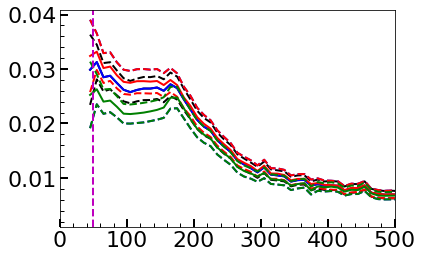

In [9]:
plt.plot(Ebins_ctr,c,'-k')
plt.plot(Ebins_ctr,c+dc[0],'--k')
plt.plot(Ebins_ctr,c-dc[1],'--k')
plt.plot(Ebins_ctr,c2,'-b')
plt.plot(Ebins_ctr,c2+dc2[0],'--b')
plt.plot(Ebins_ctr,c2-dc2[1],'--b')
plt.plot(Ebins_ctr,c3,'-r')
plt.plot(Ebins_ctr,c3+dc3[0],'--r')
plt.plot(Ebins_ctr,c3-dc3[1],'--r')
plt.plot(Ebins_ctr,c4,'-g')
plt.plot(Ebins_ctr,c4+dc4[0],'--g')
plt.plot(Ebins_ctr,c4-dc4[1],'--g')

plt.axvline(50,linestyle='--',color='m', label='50 eVee')

plt.xlim(0,500)

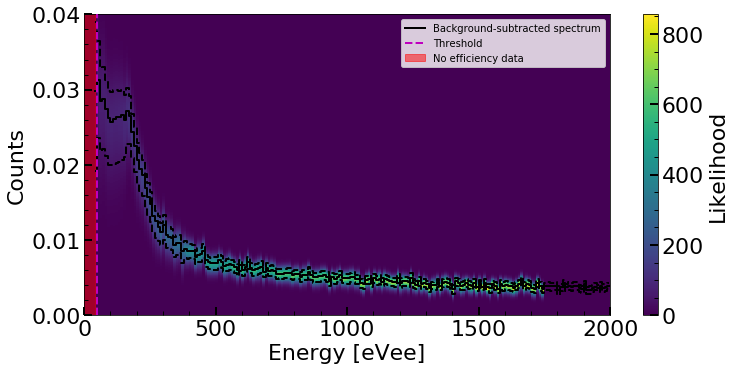

In [14]:
import likelihoods as lk

popt2=lk.getSNparsArray(c2[slice(*spec_bounds)],dc2[0][slice(*spec_bounds)],dc2[1][slice(*spec_bounds)])
fig_w=7
fig,ax = plt.subplots(1,1,figsize=(1.5*fig_w, fig_w*(.75)),sharex=True)

#ybins=np.linspace(0,4e3,1000)
ybins=np.linspace(0,0.04,1000)
ybins_ctr=(ybins[:-1]+ybins[1:])/2
bins2d=(Ebins,ybins)
counts=None
for E,popti in zip(Ebins_ctr[slice(*spec_bounds)],popt2):
    c=np.histogram2d(np.repeat(E,len(ybins_ctr)),ybins_ctr,weights=lk.fSN(ybins_ctr,*popti),bins=bins2d)[0]
    if counts is None:
        counts=c
    else:
        counts+=c
        
X, Y = np.meshgrid(Ebins,ybins)
mesh=ax.pcolormesh(X, Y, counts.T,cmap=plt.get_cmap('viridis'))

#Overlay values and uncertainty range
ax.step(Ebins_ctr, c2, color='k', linewidth=2, where='mid',zorder=3,label='Background-subtracted spectrum')
ax.step(Ebins_ctr, c2+dc2[0], color='k', linestyle='--', linewidth=2, where='mid',zorder=3)
ax.step(Ebins_ctr, c2-dc2[1], color='k', linestyle='--', linewidth=2, where='mid',zorder=3)

ax.axvline(50,linestyle='--',color='m', label='Threshold',zorder=4)
ax.axvspan(0,40,color='r', alpha=0.5, label='No efficiency data')
ax.set_ylabel('Counts')

ax.set_xlabel('Energy [eVee]')
#ax.set_xlim(0,1e3)
#ax.set_xlim(0,5e2)
ax.legend()
cbar=plt.colorbar(mesh,ax=ax)
cbar.set_label('Likelihood')
plt.tight_layout()
#plt.savefig('figures/meas_spec_PDF.png')

In [42]:
c,dc=spec.doBkgSub(r68.load_measured(cLERate='Nom',verbose=False), Ebins, Efit_min, Efit_max, doEffsyst=False, doLERsyst=False)
c1,dc1=spec.doBkgSub(r68.load_measured(cLERate='Nom',verbose=False), Ebins, Efit_min, Efit_max, doEffsyst=True, doLERsyst=False)
c2,dc2=spec.doBkgSub(r68.load_measured(cLERate='Nom',verbose=False), Ebins, Efit_min, Efit_max, doEffsyst=True, doLERsyst=True)

Loading Measured Data...
PuBe events:  (484189,)
Bkg events:  (174510,)
Loading Measured Data...
PuBe events:  (462740,)
Bkg events:  (174510,)


/home/mastx027/python/miniconda3/envs/nr_fano/lib/python3.6/site-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in subtract
  This is separate from the ipykernel package so we can avoid doing imports until


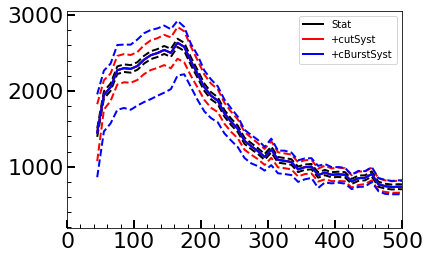

In [43]:
plt.plot(Ebins_ctr,c,'-k',label='Stat')
plt.plot(Ebins_ctr,c+dc[0],'--k')
plt.plot(Ebins_ctr,c-dc[1],'--k')
plt.plot(Ebins_ctr,c1,'-r',label='+cutSyst')
plt.plot(Ebins_ctr,c1+dc1[0],'--r')
plt.plot(Ebins_ctr,c1-dc1[1],'--r')
plt.plot(Ebins_ctr,c2,'-b',label='+cBurstSyst')
plt.plot(Ebins_ctr,c2+dc2[0],'--b')
plt.plot(Ebins_ctr,c2-dc2[1],'--b')
plt.xlim(0,500)
lt.legend()

In [49]:
print(lk.ll_SNorm(c1[slice(*spec_bounds)],*(popt2.T)))
print(lk.ll_SNorm((c1+dc1[0])[slice(*spec_bounds)],*popt2.T))
print(lk.ll_SNorm((c1-dc1[1])[slice(*spec_bounds)],*popt2.T))

-931.0295947818494
-995.4933539057404
-985.0163846663107


/home/mastx027/python/miniconda3/envs/nr_fano/lib/python3.6/site-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in true_divide
  """Entry point for launching an IPython kernel.


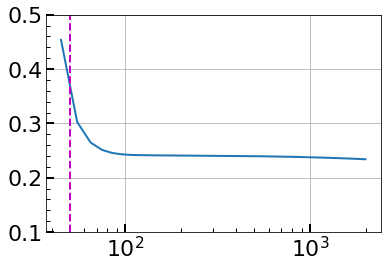

In [27]:
plt.plot(Ebins_ctr,deff_ratio/eff_ratio)
plt.axvline(50,linestyle='--',color='m', label='50 eVee')
plt.xscale('log')
#plt.yscale('log')
plt.ylim(1e-1,5e-1)
plt.grid()

/home/mastx027/python/miniconda3/envs/nr_fano/lib/python3.6/site-packages/ipykernel_launcher.py:17: RuntimeWarning: divide by zero encountered in true_divide
/home/mastx027/python/miniconda3/envs/nr_fano/lib/python3.6/site-packages/ipykernel_launcher.py:17: RuntimeWarning: invalid value encountered in true_divide


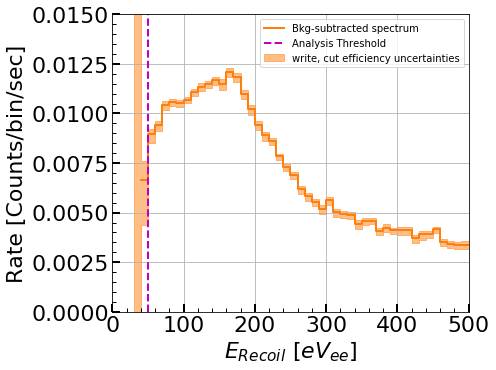

In [39]:
#Show range of bkg-subtracted spectra given efficiency and livetime uncertainties
#Disclaimer: We're assuming here all uncertainties are correlated so as to give the highest (lowest) possible PuBe count rate
#The reality is more complicated and may lead to more extreme changes to the best fit yield function
#Assuming same trigger efficiency in Bkg and PuBe, so we don't correct for it

#Using the smoothed, fitted curves
fig,ax = plt.subplots(1,1,figsize=(fig_w, 1*fig_w*(.75)),sharex=True)

R_meas_PuBe=N_meas_PuBe/meas['PuBe']['tlive']/eff.eff_write
R_meas_PuBe_hi=N_meas_PuBe/meas['PuBe']['tlive']/(eff.eff_write-eff.deff_write)
R_meas_PuBe_low=N_meas_PuBe/meas['PuBe']['tlive']/(eff.eff_write+eff.deff_write)

R_meas_bkg=N_meas_bkg/meas['Bkg']['tlive']/eff.eff_write_bkg
R_meas_bkg_hi=N_meas_bkg/meas['Bkg']['tlive']/(eff.eff_write_bkg-eff.deff_write_bkg)
R_meas_bkg_low=N_meas_bkg/meas['Bkg']['tlive']/(eff.eff_write_bkg+eff.deff_write_bkg)

eff_ratio = eff.cutEffFit(Ebins_ctr)/eff.cutEffFit_bkg(Ebins_ctr)
eff_ratio_hi=(eff.cutEffFit(Ebins_ctr) + eff.dcutEffFit(Ebins_ctr))/ (eff.cutEffFit_bkg(Ebins_ctr)-eff.dcutEffFit_bkg(Ebins_ctr))
eff_ratio_low=(eff.cutEffFit(Ebins_ctr) - eff.dcutEffFit(Ebins_ctr))/ (eff.cutEffFit_bkg(Ebins_ctr)+eff.dcutEffFit_bkg(Ebins_ctr))

R_final=R_meas_PuBe - R_meas_bkg*eff_ratio
R_final_hi=R_meas_PuBe_hi - R_meas_bkg_low*eff_ratio_low
R_final_low=R_meas_PuBe_low - R_meas_bkg_hi*eff_ratio_hi

ax.fill_between(Ebins_ctr, R_final_low, R_final_hi,
                   step='mid', color='C1',alpha=0.5, label='write, cut efficiency uncertainties')

ax.step(Ebins_ctr, R_final, where='mid', linewidth=2, color='C1', label='Bkg-subtracted spectrum')

ax.axvline(50,linestyle='--',color='m', label='Analysis Threshold')

ax.set_ylim(0,1.5e-2)
ax.set_xlim(0,500)
ax.set_xlabel(r'$E_{Recoil}~[eV_{ee}]$')
ax.set_ylabel('Rate [Counts/bin/sec]')
ax.legend()
ax.grid()

plt.tight_layout()


In [14]:
#Add in effect of burst trace systematic
meas_hi=r68.load_measured(cLERate='Hi')
meas_low=r68.load_measured(cLERate='Low')
N_meas_PuBe_hi,_ = np.histogram(meas_hi['PuBe']['E'],bins=Ebins)
N_meas_PuBe_low,_ = np.histogram(meas_low['PuBe']['E'],bins=Ebins)

Loading Measured Data...
PuBe events:  (484189,)
Bkg events:  (174510,)
Loading Measured Data...
PuBe events:  (462740,)
Bkg events:  (174510,)


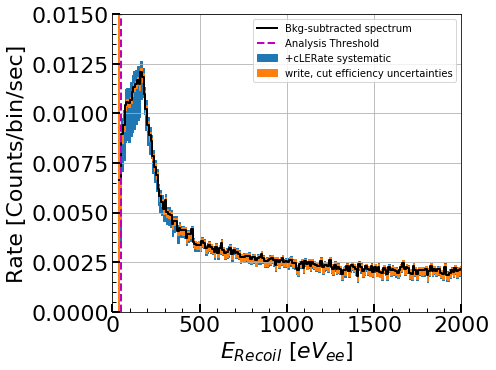

In [18]:
fig,ax = plt.subplots(1,1,figsize=(fig_w, 1*fig_w*(.75)),sharex=True)

#range due to write efficiency
R_meas_PuBe_hi=N_meas_PuBe/meas['PuBe']['tlive']/(r68_eff.eff_write-r68_eff.deff_write)
R_meas_PuBe_low=N_meas_PuBe/meas['PuBe']['tlive']/(r68_eff.eff_write+r68_eff.deff_write)

#range due to write efficiency + cLERate
R_meas_PuBe_hi_cLER=N_meas_PuBe_hi/meas['PuBe']['tlive']/(r68_eff.eff_write-r68_eff.deff_write)
R_meas_PuBe_low_cLER=N_meas_PuBe_low/meas['PuBe']['tlive']/(r68_eff.eff_write+r68_eff.deff_write)

R_final=R_meas_PuBe - R_meas_bkg*eff_ratio

#range due to write + cut efficiency
R_final_hi=R_meas_PuBe_hi - R_meas_bkg_low*eff_ratio_low
R_final_low=R_meas_PuBe_low - R_meas_bkg_hi*eff_ratio_hi

#range due to write + cut + cLERate efficiency
R_final_hi_cLER=R_meas_PuBe_hi_cLER - R_meas_bkg_low*eff_ratio_low
R_final_low_cLER=R_meas_PuBe_low_cLER - R_meas_bkg_hi*eff_ratio_hi


ax.fill_between(Ebin_ctr, R_final_low_cLER, R_final_hi_cLER,
                   step='mid', color='C0',alpha=1, label='+cLERate systematic')

ax.fill_between(Ebin_ctr, R_final_low, R_final_hi,
                   step='mid', color='C1',alpha=1, label='write, cut efficiency uncertainties')

ax.step(Ebin_ctr, R_final, where='mid', linewidth=2, color='k', label='Bkg-subtracted spectrum')

ax.axvline(50,linestyle='--',color='m', label='Analysis Threshold')

ax.set_ylim(0,1.5e-2)
ax.set_xlim(0,2000)
ax.set_xlabel(r'$E_{Recoil}~[eV_{ee}]$')
ax.set_ylabel('Rate [Counts/bin/sec]')
ax.legend()
ax.grid()

plt.tight_layout()